In [ ]:
!pip install -q mediapipe

In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
import numpy as np
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt
import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Extracting Landmarks on Face Using MediaPipe**

In [ ]:
import numpy as np
import mediapipe as mp

# To draw face mesh landmarks on the input image
def draw_facemesh_landmarks(rgb_image, facemesh_result):
    # Extract the list of detected face landmarks from the result
    face_landmarks_list = facemesh_result.multi_face_landmarks
    annotated_image = np.copy(rgb_image)

    # Iterate through each set of landmarks for each detected face
    for face_landmarks in face_landmarks_list:
        # Draw the tessellation (mesh triangles) on the face
        mp.solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,  # No specific drawing style for individual landmarks
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_tesselation_style()  # Default tessellation style
        )

        # Draw the face contours (outlines of the face)
        mp.solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,  # No specific drawing style for individual landmarks
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_contours_style()  # Default contour style
        )

        # Draw the iris (eye circles) on the face
        mp.solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp.solutions.face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,  # No specific drawing style for individual landmarks
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_iris_connections_style()  # Default iris style
        )

    # Return the annotated image with landmarks drawn on it
    return annotated_image


In [ ]:
folder_path = '/content/drive/MyDrive/Face Symmetry'
images=os.listdir(folder_path)

In [ ]:
images[0]

'asym2.png'

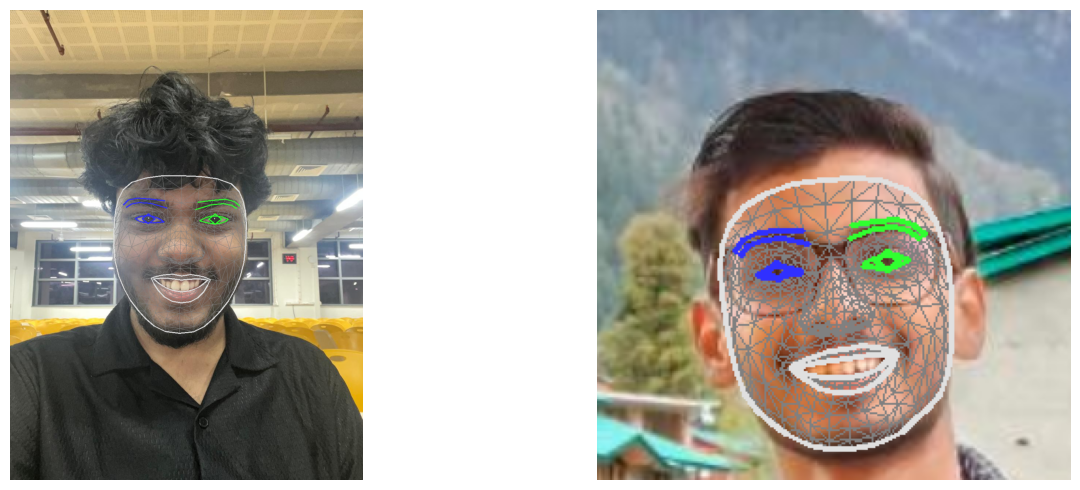

In [ ]:
# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)

image_path_list = ['/content/ronit.jpg','/content/a.png']
# for files in images:
#   os.path.join(folder_path, files)
#   image_path_list.append(os.path.join(folder_path, files))

fig, axes = plt.subplots(1, len(image_path_list), figsize=(15, 5))
# Plotting the images
for ax, image_path in zip(axes, image_path_list):
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_image)
    annotated_image = draw_facemesh_landmarks(rgb_image, results)

    ax.imshow(annotated_image)
    ax.axis('off')

plt.tight_layout()
plt.show()

We have taken certain landmarks to define the symmetry of faces

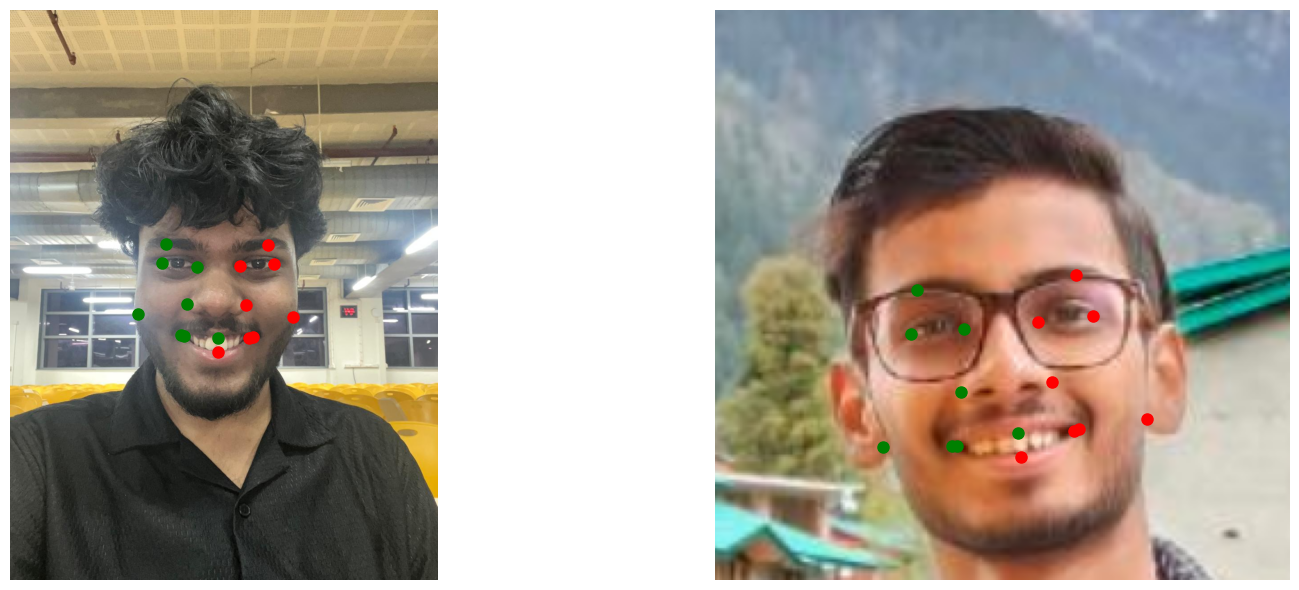

In [ ]:
# Defined the symmetrical landmark pairs for highlighting
symmetrical_pairs = [
        (33, 263),  # Outer corners of eyes
        (61, 291),  # Cheeks
        (78, 308),  # Jawline
        (13, 14) ,   # Mouth corners
        (133, 362), # Inner Eye Corners
        (129, 358), # Nostril Corners
        (132, 361), # Jaw Angles
        (52, 282)  # Outer eye end
    ]

# To plot only the symmetrical pairs for multiple images in a row
def plot_symmetrical_pairs_in_row(image_path_list):
    fig, axes = plt.subplots(1, len(image_path_list), figsize=(18, 6))

    for ax, image_path in zip(axes, image_path_list):
        image = cv2.imread(image_path)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb_image)  # Process the image with FaceMesh

        ax.imshow(rgb_image)
        ax.axis('off')

        # Check if face landmarks were detected
        if results.multi_face_landmarks:
            h, w, _ = rgb_image.shape  #image dimensions

            # Plot each pair of symmetrical landmarks
            for face_landmarks in results.multi_face_landmarks:
                for left_id, right_id in symmetrical_pairs:
                    # Get the coordinates for each landmark in the pair
                    left_landmark = face_landmarks.landmark[left_id]
                    right_landmark = face_landmarks.landmark[right_id]

                    # Convert normalized coordinates to pixel coordinates
                    left_coords = (left_landmark.x * w, left_landmark.y * h)
                    right_coords = (right_landmark.x * w, right_landmark.y * h)

                    # Plot each landmark as a dot with different colors for left and right
                    ax.plot(left_coords[0], left_coords[1], 'go', markersize=8)  # Green for left
                    ax.plot(right_coords[0], right_coords[1], 'ro', markersize=8)  # Red for right

    plt.tight_layout()
    plt.show()

# List of image paths
# image_path_list = ['/content/asm3.png', '/content/asym2.png', '/content/viv.jpg']

# Plot all images in a single row
plot_symmetrical_pairs_in_row(image_path_list)


# **Determining Symmetry Score of Faces**

In [ ]:
def euclidean_distance(pt1, pt2):   #to calculate eculedian distance between points
    return np.linalg.norm(np.array(pt1) - np.array(pt2))

# function to calculate symmetry score
def calculate_symmetry_score(landmarks, image_width):
    midline_x = image_width // 2
    distances = []

   #defined some landmarks for refrence
    symmetrical_pairs = [
        (33, 263),  # Outer corners of eyes
        (61, 291),  # Cheeks
        (78, 308),  # Jawline
        (13, 14) ,   # Mouth corners
        (133, 362), # Inner Eye Corners
        (129, 358), # Nostril Corners
        (132, 361), # Jaw Angles
        (52, 282)  # Outer eye end
    ]

    for left_idx, right_idx in symmetrical_pairs:
        left_point = landmarks[left_idx]
        right_point = landmarks[right_idx]

        # calculate distance between corresponding points on left and right sides
        mirrored_right_x = image_width - right_point[0]
        distance = euclidean_distance(left_point, (mirrored_right_x, right_point[1]))
        distances.append(distance)

    # return the average distance as a measure of asymmetry (lower score is more symmetrical)
    symmetry_score = np.mean(distances)
    return symmetry_score

In [ ]:
fig, axes = plt.subplots(1, len(image_path_list), figsize=(18, 6))

# process each image
for ax, image_path in zip(axes, image_path_list):
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_image)
    image_height, image_width, _ = image.shape

    # checked if face landmarks were detected
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # get the landmark coordinates
            landmarks = [(int(lm.x * image_width), int(lm.y * image_height)) for lm in face_landmarks.landmark]

            # calculated the symmetry score
            symmetry_score = calculate_symmetry_score(landmarks, image_width)

            # Draw the face mesh landmarks and symmetry score
            annotated_image = draw_facemesh_landmarks(rgb_image, results)
            cv2.putText(annotated_image, f'Symmetry Score: {symmetry_score:.2f}', (10, 40),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 2)
            print(f"Symmetry Score for {image_path}: {symmetry_score}")

    # Display the image in the subplot
    ax.imshow(annotated_image)
    ax.axis('off')

plt.tight_layout()
plt.show()


In above shown result the left most face has a symmetry score of 41 which is almost double of the symmetry score of the rughtmost face. Since more the symmetry score more, asymmetric the face is, it can also be confirmed through visualization that the leftmost face is much more asymmetric than rightmost face
